In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Cargamos datos
airbnb = pd.read_csv("./airbnb-listings.csv", sep=";", decimal='.') # cargamos fichero


In [3]:
#Hago la division en train y test (80%-20%)
train, test = train_test_split(airbnb, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)




Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


In [4]:
#Comienzo a trabajar con el dataset de train
dftrain = pd.read_csv('./train.csv', sep=';', decimal='.')

In [5]:
#Elimino las columnas que tienen más de la mitad de valores nulos, puesto que al inferir su valor con el valor de la media  
#estaría tomando como certeros más de la mitad de valores "adivinados"

dftrain.isna().sum().sort_values(ascending=False)/train.shape[0]


#Borro las caracteristicas que tienen más del 50% de nulos:
dftrain=dftrain.drop(['Has Availability','Host Acceptance Rate','Jurisdiction Names','License','Square Feet','Weekly Price','Security Deposit'], axis=1)

In [6]:
#Hay columnas que son atributos, de texto libre en su mayoría, que no son utiles para predecir el precio, pues son solo descripciones
dftrain=dftrain.drop(['ID','Name','Scrape ID','Listing Url','Summary','Space','Description', 'Neighborhood Overview','Notes','Transit','Access','Interaction','House Rules','Thumbnail Url', 'Picture Url','Medium Url','Picture Url','XL Picture Url', 'Host ID','Host URL','Host Name','Host Location','Host About','Host Thumbnail Url','Host Picture Url','Host Neighbourhood','Calendar Updated'], axis=1)






In [7]:
#'City', 'Country', 'State' puedo borrarlas puesto que la mayoria de instancias pertenecen a una categoria: Country=Spain,
#a City=Madrid y a State=Comunidad de Madrid

#Zipcode al contrario, presenta muchas categorias distintas, y dificulta mucho el modelo --> también la borro

#'Latitude', 'Longitude', 'Geolocation','Smart Location','Country Code','Market','Street' son columnas que no me van a aportar nada al modelo, puesto que están ligadas en todo caso a las variables de localizacion como City o Zipcode -- las borro

dftrain['Country'].value_counts()
dftrain['City'].value_counts()
dftrain['State'].value_counts()


Comunidad de Madrid               8507
Community of Madrid               1497
Madrid                             543
Catalunya                          154
Balearic Islands                   137
Illes Balears                      136
Île-de-France                       85
NY                                  53
CA                                  51
Lazio                               49
England                             45
Catalonia                           44
马德里自治区                              40
Berlin                              32
Dublin                              29
NSW                                 28
Barcelona                           27
Wien                                20
Islas Baleares                      15
ON                                  13
Veneto                              10
Noord-Holland                       10
Bruxelles                            9
North Holland                        9
DC                                   9
PM                       

In [8]:
dftrain=dftrain.drop(['City','Country','Zipcode','State','Geolocation','Latitude','Longitude','Smart Location','Country Code','Market','Street'], axis=1)


In [9]:
#Con las columnas 'First Review', 'Last Review' y 'Calendar last Scraped', me interesa sacar el plazo desde la ultima opinion recibida
#Borro 'First Review' porque no voy a utilizarla
#La columna 'Last Scraped' básicamente es similar a 'Calendar Last Scraped', por tanto, puedo optar por eliminarla
#Creo una nueva columna: 'Time Since Last Review', en donde resto la fecha de 'Calendar last Scraped' a la de 'Last Review'


from datetime import datetime
import time

#Convierto a datetime
dftrain['Last Review']= pd.to_datetime(dftrain['Last Review']) 
dftrain['Calendar last Scraped']=pd.to_datetime(dftrain['Calendar last Scraped'])


# Calculo del número de dias entre la review más reciente y la fecha de scrap
dftrain['Days Since Last Review'] = (dftrain['Calendar last Scraped'] - dftrain['Last Review']).dt.days



In [10]:
#Creo una nueva columna Host Antiq para calcular la antigüedad del host en airbnb. Para ello, resto a la fecha de Calendar Last Scraped
#el valor de la columna Host Since y borro estas últimas luego
#dftrain['Calendar last Scraped']=pd.to_datetime(airbnb['Calendar last Scraped'])

dftrain['Host Since'] = pd.to_datetime(dftrain['Host Since'])
dftrain['Host Antiq']= (dftrain['Calendar last Scraped']- dftrain['Host Since']).dt.days





In [11]:
dftrain=dftrain.drop(['Host Since','Calendar last Scraped','Last Review','Last Scraped','First Review'], axis=1)

In [12]:
#Cuantifico la columna 'Features', identificando si el Host tiene nivel Superhost o no

dftrain["Superhost"]= dftrain['Features'].str.contains("Superhost")
dftrain['Is Superhost']=LabelEncoder().fit_transform(dftrain['Superhost'])

dftrain=dftrain.drop(['Features','Superhost'], axis=1)




In [13]:
#Veo que Host_Verifications no es interesante para categorizar porque la mayoria de instancias tiene al menos email, phone y reviews, que serian las caracteristicas que mas peso podrian tener a la hora de elegir un airbnb u otro
dftrain["Host Verifications"].value_counts()
dftrain=dftrain.drop(["Host Verifications"], axis=1)




In [14]:
#La mayoria de 'Experiences Offered' está atribuida a la categoría "none" -- la borro

dftrain['Experiences Offered'].value_counts()

none        11810
business        6
family          3
social          3
romantic        2
Name: Experiences Offered, dtype: int64

In [15]:
dftrain=dftrain.drop(['Experiences Offered'],axis=1)

In [16]:
dftrain['Host Response Time'].value_counts()

within an hour        6337
within a few hours    2291
within a day          1448
a few days or more     241
Name: Host Response Time, dtype: int64

In [17]:
#Puedo borrar "Bed Type" porque la mayoria de instancias pertenecen a la categoria Bed
dftrain['Bed Type'].value_counts()
dftrain=dftrain.drop(['Bed Type'],axis=1)

In [18]:
#Para trabajar con la columna categorica 'Property Type', agrupo los valores en House, Apartment y Others
dftrain['Property Type'].value_counts()




Apartment             9598
House                 1085
Condominium            284
Bed & Breakfast        274
Loft                   248
Other                  171
Dorm                    37
Guesthouse              32
Chalet                  22
Villa                   15
Townhouse               15
Hostel                  13
Serviced apartment       9
Boutique hotel           5
Casa particular          3
Boat                     3
Camper/RV                3
Earth House              2
Bungalow                 2
Guest suite              2
Tent                     1
Name: Property Type, dtype: int64

In [19]:
#Las dos categorias con más instancias son "Apartment" y "House"
#Al resto de propiedades los claifico en "Otros"
array = ['House', 'Apartment']
dftrain['Property Type'].loc[~dftrain['Property Type'].isin(array)]='Other'


In [20]:
dftrain.dtypes

Host Response Time                 object
Host Response Rate                float64
Host Listings Count               float64
Host Total Listings Count         float64
Neighbourhood                      object
Neighbourhood Cleansed             object
Neighbourhood Group Cleansed       object
Property Type                      object
Room Type                          object
Accommodates                        int64
Bathrooms                         float64
Bedrooms                          float64
Beds                              float64
Amenities                          object
Price                             float64
Monthly Price                     float64
Cleaning Fee                      float64
Guests Included                     int64
Extra People                        int64
Minimum Nights                      int64
Maximum Nights                      int64
Availability 30                     int64
Availability 60                     int64
Availability 90                   

In [21]:
#La columna 'Room Type' solo tiene tres categorias
dftrain['Room Type'].value_counts()



Entire home/apt    7191
Private room       4471
Shared room         162
Name: Room Type, dtype: int64

In [22]:
#dftrain[['Price', 'Room Type']]




In [23]:
#Las características "Neighbourhood" y "Neighbourhood Cleansed" tienen muchísimas categorías, no me interesa, la puedo borrar
#La característica "Neighbourhood Group Cleansed" (Distrito) tiene menos categorías y un 7% de valores nulos que serán nombrados como 'Unknown'
dftrain['Neighbourhood Group Cleansed'].unique()
dftrain['Neighbourhood Group Cleansed'].isna().sum()
dftrain['Neighbourhood Cleansed'].unique()
dftrain['Neighbourhood'].unique()


array(['Jerónimos', nan, 'Carabanchel', 'Gaztambide', 'Embajadores',
       'Sol', 'Goya', 'Fuente del Berro', 'La Latina', 'Argüelles',
       'Ibiza', 'Malasaña', 'Etterbeek', 'Lista', 'Vallehermosa',
       'Ciudad Lineal', 'Palacio', 'Justicia', 'Cuatro Caminos',
       'Castillejos', 'Passy', 'Almagro', 'Guindalera', 'Barajas',
       'Acacias', 'Palos do Moguer', 'Hispanoamérica', 'Vicálvaro',
       'Arapiles', 'Esquilino', 'Pacifico', 'Cortes',
       'Puente de Vallecas', 'Trafalgar', 'Rios Rosas', 'Aluche', 'Bondi',
       'Greenwood', 'Mid-Wilshire', 'Berruguete', 'Castellana',
       'Castilla', 'Fuencarral-el Pardo', 'LB of Sutton', 'Hortaleza',
       'Indische Buurt', 'Docklands', 'Prenzlauer Berg', 'Imperial',
       'Mitte', 'Recoletos', 'Pasadena', 'La Chopera', 'Batignolles',
       'Delicias', "Dreta de l'Eixample", 'Kødbyen', 'Almenara',
       'San Blas', 'Darlinghurst', 'El Born', 'Eckington', 'El Viso',
       'La Chapelle', 'Chelsea', 'Hollywood', 'Moncloa', 'U

In [24]:
dftrain['Neighbourhood Group Cleansed'].fillna('Unknown') 

0                       Retiro
1                       Centro
2                  Carabanchel
3                       Centro
4                     Chamberí
5                       Centro
6                       Centro
7                       Centro
8                      Unknown
9                    Salamanca
10                      Centro
11                   Salamanca
12                      Retiro
13                      Centro
14           Moncloa - Aravaca
15                      Centro
16                      Retiro
17                      Centro
18                      Centro
19                      Centro
20                       Usera
21                       Usera
22                      Centro
23                     Unknown
24                   Salamanca
25                    Chamberí
26                      Centro
27                   Chamartín
28               Ciudad Lineal
29                      Centro
                 ...          
11794    San Blas - Canillejas
11795   

In [25]:
dftrain=dftrain.drop(['Neighbourhood Cleansed','Neighbourhood'], axis=1)

In [26]:
dftrain['Amenities'].isna().sum() 
dftrain['Amenities']=dftrain['Amenities'].fillna('Unknown') #La funcion .loc no admite nulos

amenities_list=dftrain['Amenities']
amenities = " ".join(map(str, amenities_list))
amenities= amenities.replace('{', '')
amenities = amenities.replace('}', ',')
amenities = amenities.replace('"', '')
amenities = [x.strip() for x in amenities.split(',')]
amenities_categories = set(amenities)
amenities_categories




{'24-Hour Check-in',
 '24-hour check-in',
 '24-hour check-in Internet',
 '24-hour check-in Kitchen',
 '24-hour check-in TV',
 '24-hour check-in Wireless Internet',
 'Air Conditioning',
 'Air conditioning',
 'Baby bath',
 'Baby bath Internet',
 'Babysitter recommendations',
 'Babysitter recommendations TV',
 'Bathtub',
 'Bathtub Internet',
 'Bathtub TV',
 'Bathtub Wireless Internet',
 'Bed linens',
 'Breakfast',
 'Buzzer/Wireless Intercom',
 'Buzzer/wireless intercom',
 'Buzzer/wireless intercom TV',
 'Cable TV',
 'Carbon Monoxide Detector',
 'Carbon monoxide detector',
 'Carbon monoxide detector TV',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s books and toys TV',
 'Children’s dinnerware Internet',
 'Children’s dinnerware TV',
 'Children’s dinnerware Wireless Internet',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Crib Internet',
 'Crib TV',
 'Crib Wireless Internet',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Dog(s) TV',
 'Doorman',
 'Doorman E

In [27]:
#Creo columnas binarias nuevas agrupando varias amenities que pueden influir en el precio y las doy el valor de 1
dftrain.loc[dftrain['Amenities'].str.contains('24-hour check-in|24-hour check-in'), 'Check in 24h'] = 1
dftrain.loc[dftrain['Amenities'].str.contains('Internet|Wireless|Wifi'), 'Wifi'] = 1
dftrain.loc[dftrain['Amenities'].str.contains('parking'), 'Parking'] = 1
dftrain.loc[dftrain['Amenities'].str.contains('Air Conditioning|Air conditioning|air conditioning'), 'Air Conditioning'] = 1
dftrain.loc[dftrain['Amenities'].str.contains('Smoking allowed'), 'Smoking allowed'] = 1
dftrain.loc[dftrain['Amenities'].str.contains('Elevator'), 'Elevator'] = 1
dftrain.loc[dftrain['Amenities'].str.contains('Pets|pet|pets|Cat(s)|Dog(s)'), 'Pets allowed'] = 1

#Reemplazo los nulos por 0
cols_nulls = ['Pets allowed','Elevator','Air Conditioning','Smoking allowed','Parking','Check in 24h','Wifi']
dftrain[cols_nulls] = dftrain[cols_nulls].fillna(0)



In [28]:
#Borro la columna "Amenities" 
dftrain=dftrain.drop(['Amenities'], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D08AF19CF8>,
      dtype=object)

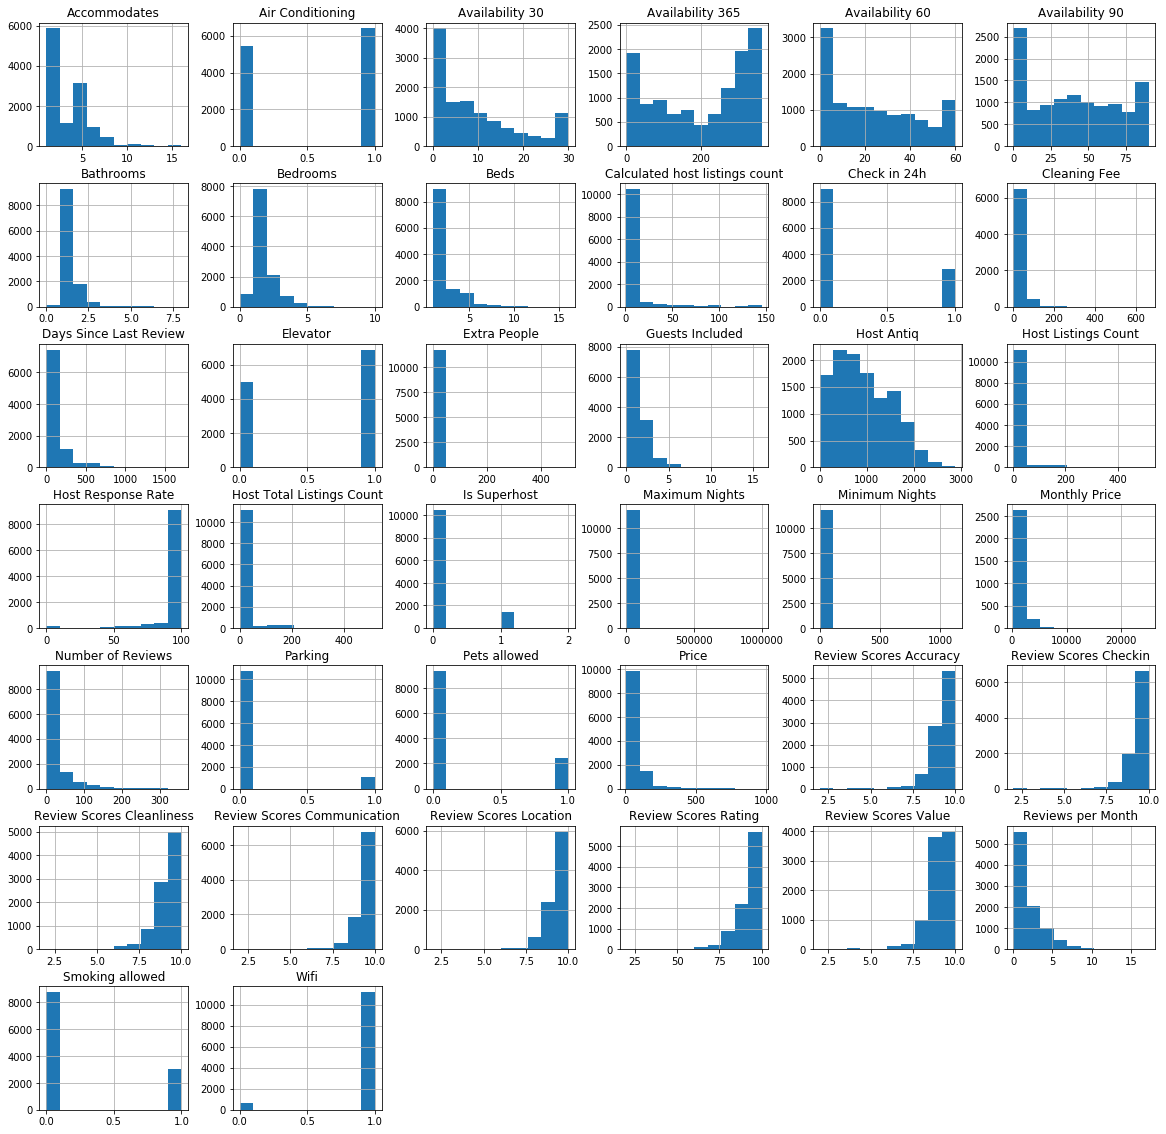

In [29]:
#Compruebo mediante plots si las variables categóricas o booleanas contienen suficiente cantidad de instancias en cada categoria para saber si vale la pena incluirlas
dftrain.hist(figsize=(20,20))

#Observo que ninguna tiene una única categoría que me haga prescindir de ella

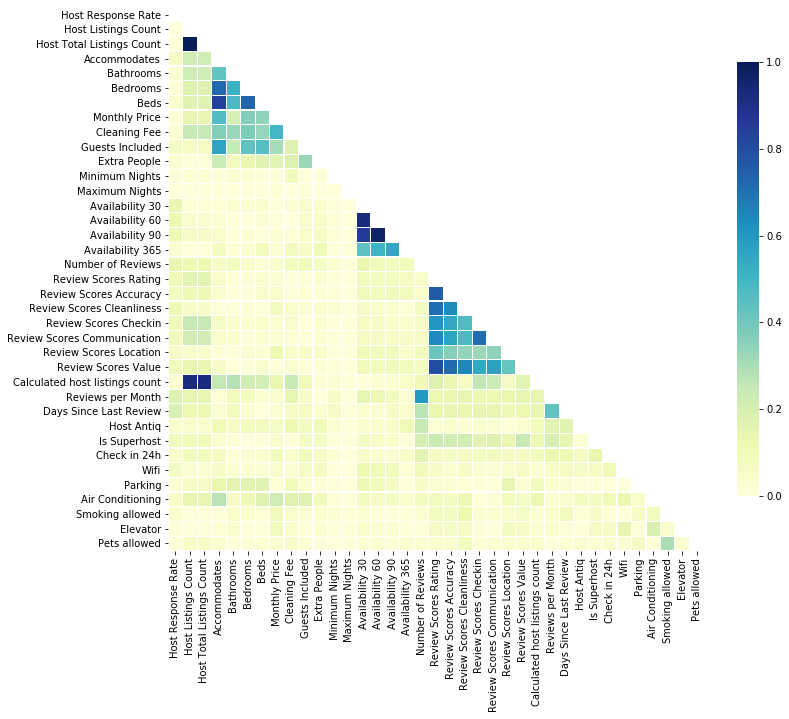

In [30]:
#Hago un grafico sencillo de correlaciones para eliminar las variables que más correladas estén
import seaborn as sns

def Triangulo_corr (dataset):
    corr = np.abs(dataset.drop(['Price'], axis=1).corr())
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8});

Triangulo_corr(dftrain)


In [31]:
#Las variables que están más correladas entre sí son:
#Calculated host listings count/Host Total Listings Count/Host Listings Count -- Borro las dos ultimas
#Availability 30/Avaliability 60/Availability 90 -- Borro las dos primeras
#Monthly Price/Weekly Price -- Borro la primera
dftrain=dftrain.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 60','Monthly Price'],axis=1)


In [32]:
#Trabajo ahora sobre las categorias categoricas para transformarlas en numéricas
categorical_feature = dftrain.dtypes==object
categorical_cols = dftrain.columns[categorical_feature]
categorical_cols

Index(['Host Response Time', 'Neighbourhood Group Cleansed', 'Property Type',
       'Room Type', 'Cancellation Policy'],
      dtype='object')

In [33]:
#Cat_col es la lista de columnas categóricas
cat_feat=dftrain.dtypes==object
cat_col=dftrain.columns[cat_feat]
cat_col


#Mean-encoder en todas las columnas categóricas
mean_map = {}
for c in cat_col:
    means = dftrain.groupby(c)['Price'].mean()
    dftrain[c] = dftrain[c].map(means)
    mean_map[c]=means
    
mean_map #Guardo las medidas para aplicarlo luego en dftest



{'Host Response Time': Host Response Time
 a few days or more    75.689076
 within a day          75.280775
 within a few hours    73.135867
 within an hour        73.856443
 Name: Price, dtype: float64,
 'Neighbourhood Group Cleansed': Neighbourhood Group Cleansed
 Arganzuela                   46.120501
 Ballard                     218.000000
 Barajas                      58.514706
 Beacon Hill                  65.000000
 Bronx                        39.000000
 Brooklyn                     94.782609
 Capitol Hill                114.000000
 Carabanchel                  39.716263
 Centro                       72.889134
 Chamartín                    79.261484
 Chamberí                     72.670588
 Charlottenburg-Wilm.         70.000000
 Ciudad Lineal                45.156627
 Ciutat Vella                114.888889
 Eixample                    139.489796
 Friedrichshain-Kreuzberg     48.545455
 Fuencarral - El Pardo       101.068182
 Gràcia                       91.354839
 Horta-Guinard

In [34]:
# Ahora que todas las caracteristicas son cuantitativas, completo valores faltantes 
col=dftrain.columns
mean_na_train={}
for c in col:
    mean = dftrain[c].mean()
    dftrain[c] = dftrain[c].fillna(mean)  
    mean_na_train[c]=mean
    
    
mean_na_train 
mean_df = pd.Series(mean_na_train) 
mean_df #Guardo las medidas de medias para aplicarlo luego en dftest

Host Response Time                 73.939147
Host Response Rate                 94.803722
Neighbourhood Group Cleansed       69.113046
Property Type                      73.712845
Room Type                          73.730557
Accommodates                        3.277486
Bathrooms                           1.285229
Bedrooms                            1.344290
Beds                                2.049122
Price                              73.712592
Cleaning Fee                       32.073129
Guests Included                     1.581614
Extra People                        7.637601
Minimum Nights                      3.109946
Maximum Nights                    961.732070
Availability 90                    39.803958
Availability 365                  202.217185
Number of Reviews                  22.664834
Review Scores Rating               91.628179
Review Scores Accuracy              9.410040
Review Scores Cleanliness           9.320726
Review Scores Checkin               9.623905
Review Sco

In [35]:
#Hago las mismas transformaciones y drops a dftest
dftest = pd.read_csv('./test.csv', sep=';', decimal='.')


dftest = dftest.drop(['Has Availability','Host Acceptance Rate','Jurisdiction Names','License','Square Feet','Weekly Price','Security Deposit'], axis=1)
dftest = dftest.drop(['ID','Name','Scrape ID','Listing Url','Summary','Space','Description', 'Neighborhood Overview','Notes','Transit','Access','Interaction','House Rules','Thumbnail Url', 'Picture Url','Medium Url','Picture Url','XL Picture Url', 'Host ID','Host URL','Host Name','Host Location','Host About','Host Thumbnail Url','Host Picture Url','Host Neighbourhood','Calendar Updated'], axis=1)
dftest = dftest.drop(['City','Country','Zipcode','State','Geolocation','Latitude','Longitude','Smart Location','Country Code','Market','Street'], axis=1)



#Convierto a datetime
dftest['Last Review']= pd.to_datetime(dftest['Last Review']) 
dftest['Calendar last Scraped']=pd.to_datetime(dftest['Calendar last Scraped'])

# Calculo del número de dias entre la review más reciente y la fecha de scrap
dftest['Days Since Last Review'] = (dftest['Calendar last Scraped'] - dftest['Last Review']).dt.days

dftest['Host Since'] = pd.to_datetime(dftest['Host Since'])
dftest['Host Antiq']= (dftest['Calendar last Scraped']- dftest['Host Since']).dt.days

dftest = dftest.drop(['Host Since','Calendar last Scraped','Last Review','Last Scraped','First Review'], axis=1)

dftest["Superhost"]= dftest['Features'].str.contains("Superhost")
dftest['Is Superhost']=LabelEncoder().fit_transform(dftest['Superhost'])

dftest = dftest.drop(['Features','Superhost'], axis=1)

dftest = dftest.drop(["Host Verifications"], axis=1)
dftest = dftest.drop(['Experiences Offered'],axis=1)
dftest = dftest.drop(['Bed Type'],axis=1)
array = ['House', 'Apartment']
dftest['Property Type'].loc[~dftest['Property Type'].isin(array)]='Other'
dftest['Neighbourhood Group Cleansed'].fillna('Unknown') 
dftest=dftest.drop(['Neighbourhood Cleansed','Neighbourhood'], axis=1)

dftest['Amenities'].isna().sum() 
dftest['Amenities']=dftest['Amenities'].fillna('Unknown') #La funcion .loc no admite nulos

amenities_list=dftest['Amenities']
amenities = " ".join(map(str, amenities_list))
amenities= amenities.replace('{', '')
amenities = amenities.replace('}', ',')
amenities = amenities.replace('"', '')
amenities = [x.strip() for x in amenities.split(',')]
amenities_categories = set(amenities)
amenities_categories

dftest.loc[dftest['Amenities'].str.contains('24-hour check-in|24-hour check-in'), 'Check in 24h'] = 1
dftest.loc[dftest['Amenities'].str.contains('Internet|Wireless|Wifi'), 'Wifi'] = 1
dftest.loc[dftest['Amenities'].str.contains('parking'), 'Parking'] = 1
dftest.loc[dftest['Amenities'].str.contains('Air Conditioning|Air conditioning|air conditioning'), 'Air Conditioning'] = 1
dftest.loc[dftest['Amenities'].str.contains('Smoking allowed'), 'Smoking allowed'] = 1
dftest.loc[dftest['Amenities'].str.contains('Elevator'), 'Elevator'] = 1
dftest.loc[dftest['Amenities'].str.contains('Pets|pet|pets|Cat(s)|Dog(s)'), 'Pets allowed'] = 1

#Reemplazo los nulos por 0
cols_nulls = ['Pets allowed','Elevator','Air Conditioning','Smoking allowed','Parking','Check in 24h','Wifi']
dftest[cols_nulls]=dftest[cols_nulls].fillna(0)
dftest=dftest.drop(['Amenities'], axis=1)

dftest = dftest.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 60','Monthly Price'],axis=1)

categorical_feature = dftest.dtypes==object
categorical_cols = dftest.columns[categorical_feature]
categorical_cols



Index(['Host Response Time', 'Neighbourhood Group Cleansed', 'Property Type',
       'Room Type', 'Cancellation Policy'],
      dtype='object')

In [36]:
#Compruebo que los cambios se hayan aplicado correctamente
dftest

Host Response Time  Host Response Rate Neighbourhood Group Cleansed  \
0         within an hour               100.0                   Villaverde   
1         within an hour               100.0                       Centro   
2     within a few hours                80.0                     Chamberí   
3                    NaN                 NaN                       Latina   
4                    NaN                 NaN                       Centro   
5         within an hour               100.0                Ciudad Lineal   
6     within a few hours                98.0                       Centro   
7                    NaN                 NaN                       Retiro   
8           within a day                67.0                        Usera   
9           within a day                60.0                          NaN   
10    a few days or more                 0.0                       Centro   
11        within an hour               100.0                       Centro   
12          within a day                80.0                       Centro   
13    within a few hours                89.0            Moncloa - Aravaca   
14    within a few hours               100.0                Ciudad Lineal   
15    within a few hours               100.0                       Centro   
16        within an hour                87.0                       Latina   
17          within a day                67.0                Ciudad Lineal   
18    within a few hours                86.0                       Centro   
19        within an hour               100.0                       Centro   
20          within a day               100.0                       Centro   
21        within an hour               100.0                       Centro   
22        within an hour                83.0                Ciudad Lineal   
23        within an hour                96.0                       Centro   
24        within an hour               100.0                       Centro   
25        within an hour               100.0                       Centro   
26    within a few hours               100.0                       Centro   
27                   NaN                 NaN                   Arganzuela   
28        within an hour               100.0                       Centro   
29        within an hour               100.0            Moncloa - Aravaca   
...                  ...                 ...                          ...   
2926      within an hour               100.0                    Hortaleza   
2927      within an hour               100.0                       Centro   
2928      within an hour                98.0                       Latina   
2929  within a few hours               100.0                   Arganzuela   
2930      within an hour               100.0                    Salamanca   
2931  within a few hours               100.0                    Chamartín   
2932      within an hour               100.0                       Centro   
2933        within a day               100.0                       Centro   
2934      within an hour               100.0                       Retiro   
2935  within a few hours               100.0                       Centro   
2936      within an hour               100.0                       Centro   
2937      within an hour               100.0                       Centro   
2938  a few days or more                33.0                          NaN   
2939                 NaN                 NaN                     Chamberí   
2940  within a few hours               100.0                     Brooklyn   
2941      within an hour               100.0                       Centro   
2942      within an hour               100.0                       Centro   
2943      within an hour               100.0                       Centro   
2944                 NaN                 NaN                  Carabanchel   
2945      within an hour                98.0                       Tetuán   
29

In [37]:
#DFTEST

#Cat_col es la lista de columnas categóricas
cat_feat=dftest.dtypes==object
cat_col=dftest.columns[cat_feat]
cat_col

#Mean-encoder en todas las columnas categóricas
mean_map_test= {}
for c in cat_col:
    means = mean_map[c]
    dftest[c] = dftest[c].map(means)
    mean_map_test[c]=means
mean_map_test


{'Host Response Time': Host Response Time
 a few days or more    75.689076
 within a day          75.280775
 within a few hours    73.135867
 within an hour        73.856443
 Name: Price, dtype: float64,
 'Neighbourhood Group Cleansed': Neighbourhood Group Cleansed
 Arganzuela                   46.120501
 Ballard                     218.000000
 Barajas                      58.514706
 Beacon Hill                  65.000000
 Bronx                        39.000000
 Brooklyn                     94.782609
 Capitol Hill                114.000000
 Carabanchel                  39.716263
 Centro                       72.889134
 Chamartín                    79.261484
 Chamberí                     72.670588
 Charlottenburg-Wilm.         70.000000
 Ciudad Lineal                45.156627
 Ciutat Vella                114.888889
 Eixample                    139.489796
 Friedrichshain-Kreuzberg     48.545455
 Fuencarral - El Pardo       101.068182
 Gràcia                       91.354839
 Horta-Guinard

In [38]:
#DFTEST

# Completo valores faltantes datos cuantititavos
col=dftest.columns
mean_na_test={}

for c in col:
    means = mean_df[c]
    dftest[c] = dftest[c].fillna(means)  
    mean_na_test[c]=means
    
mean_na_test



{'Host Response Time': 73.93914730324796,
 'Host Response Rate': 94.80372201221286,
 'Neighbourhood Group Cleansed': 69.11304626508708,
 'Property Type': 73.71284469125335,
 'Room Type': 73.7305573364805,
 'Accommodates': 3.2774864682002707,
 'Bathrooms': 1.2852292020373515,
 'Bedrooms': 1.3442900711623178,
 'Beds': 2.0491219139730212,
 'Price': 73.71259209077822,
 'Cleaning Fee': 32.0731287639805,
 'Guests Included': 1.5816136671177266,
 'Extra People': 7.63760148849797,
 'Minimum Nights': 3.1099458728010827,
 'Maximum Nights': 961.7320703653586,
 'Availability 90': 39.80395805142084,
 'Availability 365': 202.21718538565628,
 'Number of Reviews': 22.664834235453316,
 'Review Scores Rating': 91.62817854414493,
 'Review Scores Accuracy': 9.410040468117685,
 'Review Scores Cleanliness': 9.320725841714037,
 'Review Scores Checkin': 9.623905429071804,
 'Review Scores Communication': 9.647862687219854,
 'Review Scores Location': 9.53465454943611,
 'Review Scores Value': 9.211344721857206,
 

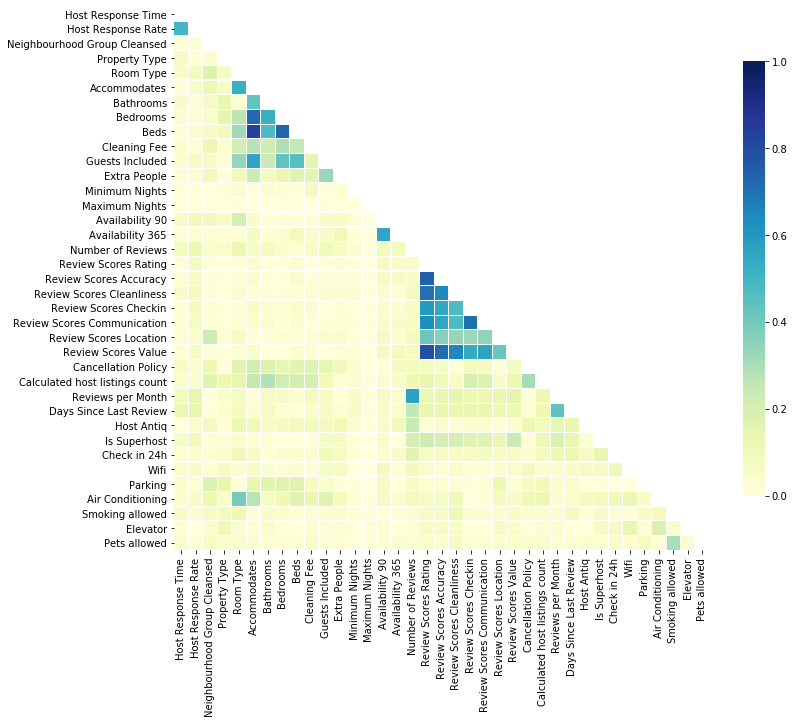

In [39]:
#Tras pasar todas las columnas a tipo numérico y rellenar Nan, vuelvo a sacar un gráfico de correlación para ver si hay caracteristicas correlacionadas
#No hay ninguna que tenga una corr de más de 0.9
Triangulo_corr (dftrain)#(dftest)

In [40]:
# Controlo que no haya valores faltantes
dftrain.isnull().any().any()
dftest.isnull().any().any()



False

In [41]:
#Y controlo que los tipos de variables sean los correctos
dftrain.dtypes
dftest.dtypes

Host Response Time                float64
Host Response Rate                float64
Neighbourhood Group Cleansed      float64
Property Type                     float64
Room Type                         float64
Accommodates                        int64
Bathrooms                         float64
Bedrooms                          float64
Beds                              float64
Price                             float64
Cleaning Fee                      float64
Guests Included                     int64
Extra People                        int64
Minimum Nights                      int64
Maximum Nights                      int64
Availability 90                     int64
Availability 365                    int64
Number of Reviews                   int64
Review Scores Rating              float64
Review Scores Accuracy            float64
Review Scores Cleanliness         float64
Review Scores Checkin             float64
Review Scores Communication       float64
Review Scores Location            

In [42]:
#COMIENZO A IMPLEMENTAR MODELOS DE MACHINE LEARNING

#Preparo los datos de train y test

columns_to_drop=[]
columns_to_drop=('Price')
features= dftrain.columns.drop(columns_to_drop)


x_train = dftrain[features].values    
y_train = dftrain['Price'].values  # nos quedamos con la 1ª columna, price

x_test = dftest[features].values    
y_test = dftest['Price'].values # nos quedamos con la 1ª columna, price

                 #Escalado 
scaler = preprocessing.StandardScaler().fit(x_train)
XtrainScaled = scaler.transform(x_train)

XtestScaled = scaler.transform(x_test) 

In [43]:
dftrain.describe().T



count        mean          std        min  \
Host Response Time              11824.0   73.939147     0.641537  73.135867   
Host Response Rate              11824.0   94.803722    14.242245   0.000000   
Neighbourhood Group Cleansed    11824.0   69.113046    16.046992  20.000000   
Property Type                   11824.0   73.712845     7.277651  64.872583   
Room Type                       11824.0   73.730557    26.648801  31.320988   
Accommodates                    11824.0    3.277486     2.093973   1.000000   
Bathrooms                       11824.0    1.285229     0.663453   0.000000   
Bedrooms                        11824.0    1.344290     0.904414   0.000000   
Beds                            11824.0    2.049122     1.620947   1.000000   
Price                           11824.0   73.712592    71.579394   9.000000   
Cleaning Fee                    11824.0   32.073129    24.020686   0.000000   
Guests Included                 11824.0    1.581614     1.160518   0.000000   
Extra People                    11824.0    7.637601    12.373491   0.000000   
Minimum Nights                  11824.0    3.109946    13.427477   1.000000   
Maximum Nights                  11824.0  961.732070  9387.640642   1.000000   
Availability 90                 11824.0   39.803958    29.663314   0.000000   
Availability 365                11824.0  202.217185   128.006830   0.000000   
Number of Reviews               11824.0   22.664834    38.092338   0.000000   
Review Scores Rating            11824.0   91.628179     8.043852  20.000000   
Review Scores Accuracy          11824.0    9.410040     0.824832   2.000000   
Review Scores Cleanliness       11824.0    9.320726     0.883514   2.000000   
Review Scores Checkin           11824.0    9.623905     0.706762   2.000000   
Review Scores Communication     11824.0    9.647863     0.673238   2.000000   
Review Scores Location          11824.0    9.534655     0.677091   2.000000   
Review Scores Value             11824.0    9.211345     0.846410   2.000000   
Cancellation Policy             11824.0   73.708597    11.944839  64.194133   
Calculated host listings count  11824.0    9.615313    23.791554   1.000000   
Reviews per Month               11824.0    1.873326     1.656340   0.020000   
Days Since Last Review          11824.0  103.311181   147.910658   0.000000   
Host Antiq                      11824.0  932.085357   588.389258   1.000000   
Is Superhost                    11824.0    0.116965     0.321656   0.000000   
Check in 24h                    11824.0    0.243572     0.429256   0.000000   
Wifi                            11824.0    0.947057     0.223930   0.000000   
Parking                         11824.0    0.088464     0.283981   0.000000   
Air Conditioning                11824.0    0.541103     0.498329   0.000000   
Smoking allowed                 11824.0    0.258542     0.437852   0.000000   
Elevator                        11824.0    0.580937     0.493427   0.000000   
Pets allowed                    11824.0    0.208728     0.406417   0.000000   

                                       25%          50%          75%  \
Host Response Time               73.856443    73.856443    73.939147   
Host Response Rate               94.803722   100.000000   100.000000   
Neighbourhood Group Cleansed     69.113046    72.889134    72.889134   
Property Type                    72.294431    72.294431    72.294431   
Room Type                        40.894831    95.101560    95.101560   
Accommodates                      2.000000     3.000000     4.000000   
Bathrooms                         1.000000     1.000000     1.000000   
Bedrooms                          1.000000     1.000000     2.000000   
Beds                              1.000000     2.000000     2.000000   
Price                            34.000000    55.000000    87.000000   
Cleaning Fee                     20.000000    32.073129    32.073129   
Guests Included                   1.000000     1.000000     2.000000   
Extra People    

best mean cross-validation score: -2756.693
best parameters: {'alpha': 0.0774263682681127}


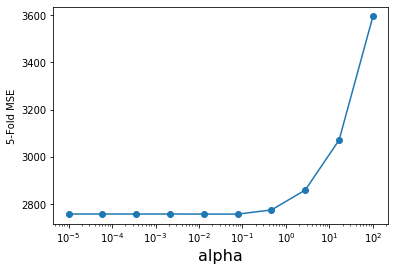

In [44]:
#Primeramente utilizo un algoritmo sencillo de EMBEDDED (LASSO) que permite trabajar sin overfitting


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-5,2,10)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(x_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()



In [45]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']*100
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(features,w):
    print(f,wi)

MSE Modelo Lasso (train): 3.09e+03
MSE Modelo Lasso (test) : 3.17e+03
RMSE Modelo Lasso (train): 55.6
RMSE Modelo Lasso (test) : 56.3
Host Response Time 0.0
Host Response Rate -0.0
Neighbourhood Group Cleansed 3.041072100362632
Property Type 0.0
Room Type 5.131456043728495
Accommodates 14.609509376885152
Bathrooms 4.765080283099565
Bedrooms 8.351803386116904
Beds 0.0
Cleaning Fee 15.03524605009153
Guests Included 0.0
Extra People -0.0
Minimum Nights 0.0
Maximum Nights 0.0
Availability 90 0.0
Availability 365 0.0
Number of Reviews -0.0
Review Scores Rating 0.0
Review Scores Accuracy 0.0
Review Scores Cleanliness 0.0
Review Scores Checkin 0.0
Review Scores Communication 0.0
Review Scores Location 0.0
Review Scores Value 0.0
Cancellation Policy 0.0
Calculated host listings count 0.0
Reviews per Month -0.0
Days Since Last Review 0.0
Host Antiq 0.0
Is Superhost 0.0
Check in 24h 0.0
Wifi -0.0
Parking 0.0
Air Conditioning 0.0
Smoking allowed -0.0
Elevator -0.0
Pets allowed -0.0


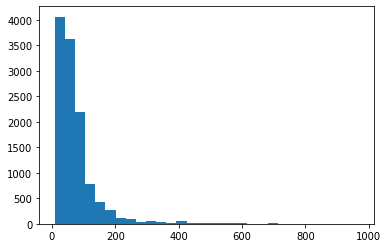

In [45]:
#Veo que el error es demasiado alto
#Hago un plot de la variable objetivo para ver qué forma tiene -- y veo que está desplazada hacia la izquierda --> NORMALIZO
plt.hist(dftrain['Price'], bins=30)
plt.show()

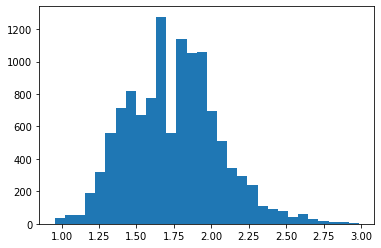

In [46]:
#Transformo la variable objetivo a escala logaritmica para mejorar la distribucion y repito LASSO
plt.hist(np.log10(dftrain['Price']), bins=30)
plt.show()


In [47]:
#Modifico los parametros de train con log10
y_train_log = np.log10(dftrain['Price'].values)      
y_test_log = np.log10(dftest['Price'].values)

best mean cross-validation score: -0.033
best parameters: {'alpha': 0.00029763514416313193}


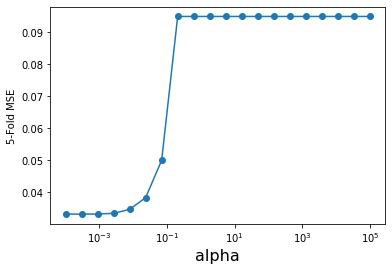

In [48]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-4,5,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train_log)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()



In [49]:
#Mediante este algoritmo de filtrado, puedo ver qué caracteristicas son las menos relevantes.

from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']*100
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train_log)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train_log,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test_log,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(features,w):
    print(f,wi)

MSE Modelo Lasso (train): 0.0393
MSE Modelo Lasso (test) : 0.0398
RMSE Modelo Lasso (train): 0.198
RMSE Modelo Lasso (test) : 0.199
Host Response Time 0.0
Host Response Rate -0.0
Neighbourhood Group Cleansed 0.034971549176881035
Property Type 0.0
Room Type 0.11546357824636941
Accommodates 0.058155694254016156
Bathrooms 0.00013071560181508737
Bedrooms 0.031366072576070644
Beds 0.0
Cleaning Fee 0.03580081039429608
Guests Included 0.0
Extra People 0.0
Minimum Nights -0.0
Maximum Nights 0.0
Availability 90 0.0
Availability 365 0.0
Number of Reviews -0.0
Review Scores Rating 0.0
Review Scores Accuracy 0.0
Review Scores Cleanliness 0.0
Review Scores Checkin 0.0
Review Scores Communication 0.0
Review Scores Location 0.0
Review Scores Value 0.0
Cancellation Policy 0.0
Calculated host listings count 0.0
Reviews per Month -0.0
Days Since Last Review 0.0
Host Antiq 0.0
Is Superhost 0.0
Check in 24h 0.0
Wifi -0.0
Parking 0.0
Air Conditioning 0.006494644742012841
Smoking allowed -0.0
Elevator 0.0
P

best mean cross-validation score: 0.690
best parameters: {'max_depth': 9.0}


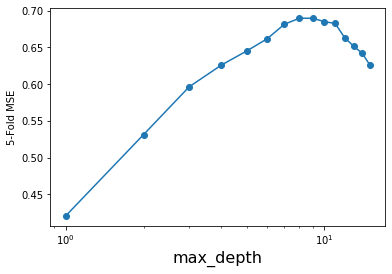

In [50]:
#Utilizo ahora un ARBOL DE DECISION para mejorar resultados

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score


max_depth = np.linspace(1, 15, 15 ) 
#max_depth = np.linspace(1, 30, 10 ) Restultado peor (Best mean cv score:0.68 y maxdepth:10.6)
param_grid = {'max_depth': max_depth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train_log)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

grid.cv_results_
scores = np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(max_depth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()






In [73]:
maxDepthOptimo = grid.best_params_['max_depth']
#treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(x_train,y_train_log) #PROFUNDIDAD=9 Score train=0.788/Score Test: 0.68 
treeModel = DecisionTreeRegressor(max_depth=8).fit(x_train,y_train_log) #PROFUNDIDAD=8  
print("Score Train: ",treeModel.score(x_train,y_train_log))
print("Score Test: ",treeModel.score(x_test,y_test_log))

#Veo una diferencia notable entre Score Train y Score Test, por lo que, VOY BAJANDO LA PROFUNDIDAD. Con una profundidad de 6
#penalizo mucho el sesgo pero mejoro interpretabilidad

KeyError: 'max_depth'

best mean cross-validation score: 0.772
best parameters: {'max_depth': 14}


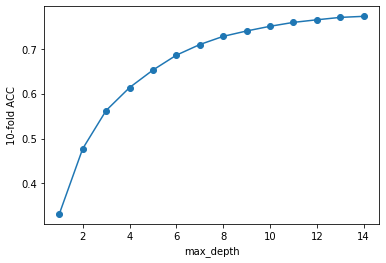

In [57]:
#Como tercera opcion, utilizo un RANDOM FOREST

from sklearn.ensemble import RandomForestRegressor

# grid search
maxDepth = range(1,15) #mejores resultados con este rango
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(x_train, y_train_log)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [68]:
#Profundidad=14 -- score Train es muy distinto a Score Test -- bajo la profundidad para mejorar la interpretabilidad

maxDepthOptimo = grid.best_params_['max_depth']
treeModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(x_train,y_train_log)

print("Score Train: ",treeModel.score(x_train,y_train_log))
print("Score Test: ",treeModel.score(x_test,y_test_log))

Score Train:  0.9007315793455047
Score Test:  0.7680534004386478


In [65]:
#Bajo 3 unidades la profundidad del arbol, a 11
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = RandomForestRegressor(max_depth=11,n_estimators=200,max_features='sqrt').fit(x_train,y_train_log)

print("Score Train: ",treeModel.score(x_train,y_train_log))
print("Score Test: ",treeModel.score(x_test,y_test_log))

Score Train:  0.8409242036339334
Score Test:  0.7543254876926152


In [66]:
#BBAJO LA PROFUNDIDAD = 8 --> Me da mejor resultado que Decision Tree Regressor, como esperaba
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = RandomForestRegressor(max_depth=8,n_estimators=200,max_features='sqrt').fit(x_train,y_train_log)

print("Score Train: ",treeModel.score(x_train,y_train_log))
print("Score Test: ",treeModel.score(x_test,y_test_log))

Score Train:  0.7656123648778969
Score Test:  0.7259318892197709


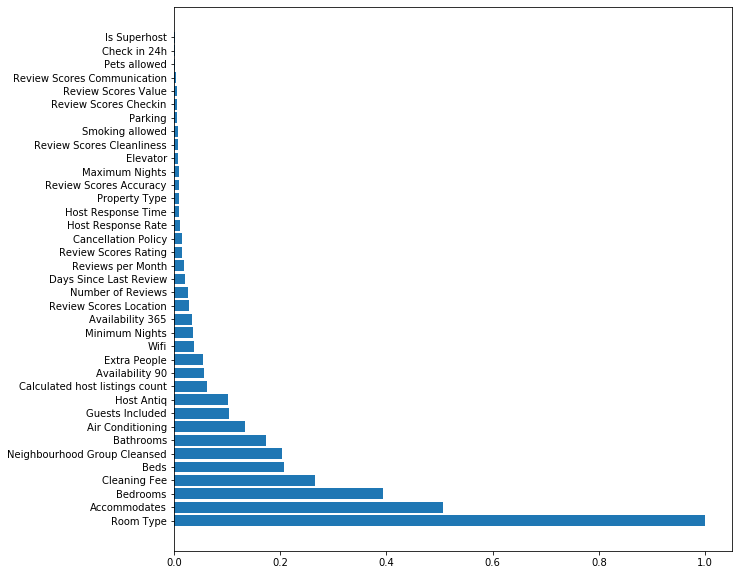

In [67]:
from sklearn import tree

importances = treeModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(x_train.shape[1]),importances[indices])
plt.yticks(range(x_train.shape[1]),features[indices])
plt.show()

In [68]:
#Por último, implemento un BOOSTING, con el que espero resultados mejores que los anteriores

from sklearn.ensemble import GradientBoostingRegressor

Niterations = [25,50,75,100,125,150,175,200,300]
learningRate = [0.5,0.1,0.05,0.01]
#max_depth=2

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=2), param_grid=param_grid, cv = 5)
grid.fit(x_train, y_train_log)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.771
best parameters: {'learning_rate': 0.5, 'n_estimators': 300}


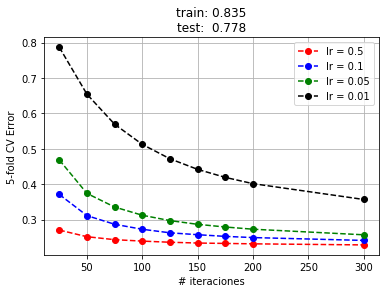

In [69]:
# calculamos métricas globales
lRateOptimo = grid.best_params_['learning_rate']
nEstimatorsOptimo = grid.best_params_['n_estimators']

bt = GradientBoostingRegressor(random_state=0, max_depth=2,learning_rate=lRateOptimo, n_estimators=300) 
bt.fit(x_train,y_train_log)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(x_train,y_train_log),bt.score(x_test,y_test_log)))
plt.grid()
plt.show()

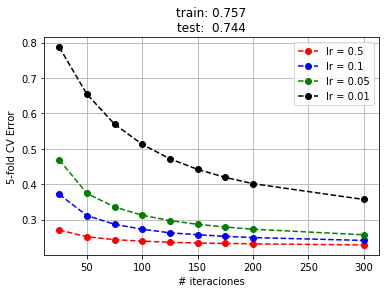

In [70]:
#MODIFICO PARAMETROS PARA MEJORAR INTERPRETABILIDAD: REDUZCO LEARNING RATE
lRateOptimo = grid.best_params_['learning_rate']
nEstimatorsOptimo = grid.best_params_['n_estimators']

#learning rate=0.05 
bt = GradientBoostingRegressor(random_state=0, max_depth=2,learning_rate=0.05, n_estimators=300) 
bt.fit(x_train,y_train_log)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(x_train,y_train_log),bt.score(x_test,y_test_log)))
plt.grid()
plt.show()

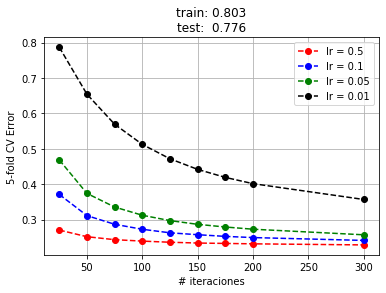

In [71]:
#MODIFICO PARAMETROS: aumento un poco la PROFUNDIDAD , con lo que consigo un buen resultado de SCORE TRAIN y muy similar a SCORE TEST
lRateOptimo = grid.best_params_['learning_rate']
nEstimatorsOptimo = grid.best_params_['n_estimators']

#learning rate=0.05 y max_depth=3
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=0.05, n_estimators=300) 
bt.fit(x_train,y_train_log)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(x_train,y_train_log),bt.score(x_test,y_test_log)))
plt.grid()
plt.show()

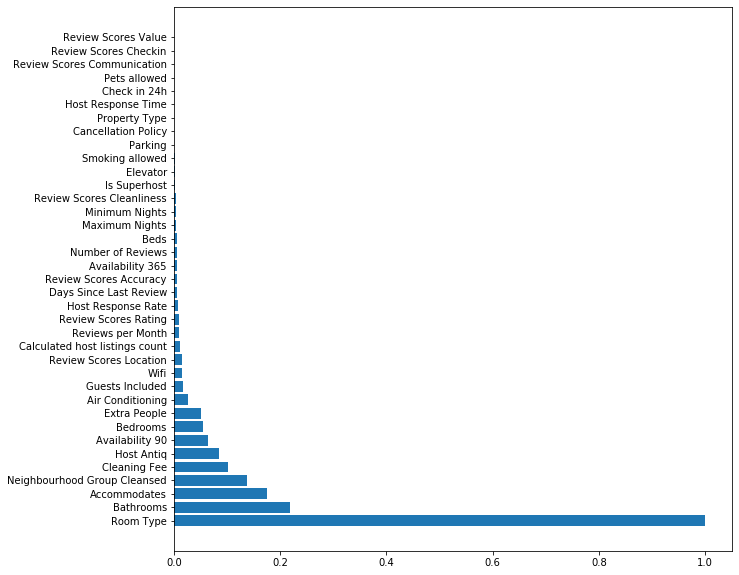

In [72]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(x_train.shape[1]),importances[indices])
plt.yticks(range(x_train.shape[1]),features[indices])
plt.show()

Tras probar el método EMBEDDED (Lasso) y dos de ARBOLES (Random Forest y Boosted), la conclusion es que el mejor algoritmo es el BOOSTING. 

El algoritmo de Boosting, da como características más importantes para predecir el modelo:

-Tipo de habitacion (Apartamento Entero/Habitacion Privada/Habitacion compartida)
-Baños 
-Accommodates
-Distrito
-Fianza de Limpieza


Estas variables, también son las supervivientes del algoritmo LASSO

Room Type 0.11546357824636941
Accommodates 0.058155694254016156
Cleaning Fee 0.03580081039429608
Neighbourhood Group Cleansed 0.034971549176881035
Bedrooms 0.031366072576070644
Air Conditioning 0.006494644742012841
Bathrooms 0.00013071560181508737







